# Analyses for SPP

In [1]:
import os
import sys
import urllib, io

import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

### Load Data

In [49]:
# Trial_end data
iterationName = 'pilot4'

trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iterationName))
df = pd.read_csv(trial_path)

In [50]:
# Settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iterationName))
dfs = pd.read_csv(settled_path)

In [51]:
# Explore_end data
explore_path = os.path.join(csv_dir,'block_silhouette_explore_{}.csv'.format(iterationName))
dfe = pd.read_csv(explore_path)

In [52]:
# Exclude outliers
low_scores = df[(df.trialNum == 15) & (df.score == 0)]['gameID']

df = df[~df.gameID.isin(low_scores)]
dfs = dfs[~dfs.gameID.isin(low_scores)]
dfe = dfe[~dfe.gameID.isin(low_scores)]

## Preprocessing

### Block Data

In [53]:
# Add a condition for physical with 0 actions
dfs['extendedCondition'] = dfs['condition']
trialInfo = df[['gameID','trialNum','numBlocksExplore']]
dfs = dfs.merge(trialInfo, on=['gameID', 'trialNum'], how='left')
dfs.loc[(df.condition == 'physical') & (dfs.numBlocksExplore == 0),'extendedCondition'] = 'no_action_physical'


# Add useful variables to dataframe
dfs['subject_trial'] = dfs['gameID'] + '_' + str(dfs['trialNum'])
dfs['condition_number'] = np.where(dfs['condition']=='mental', 100, 2)
dfs['condition_code'] = dfs['condition_number'] + dfs['trialNum']
dfs['time_bin'] = np.round_(dfs['timePlaced']/10000)*10000

dfs_build = dfs[dfs.phase == 'build']
dfs_explore = dfs[dfs.phase == 'explore']

### Explore Data

In [54]:
dfe

,Unnamed: 0,gameID,trialNum,phase,condition,eventType,score,normedScore,numBlocks,timeAbsolute,timeRelative,currBonus,exploreResets,allVertices,nPracticeAttempts,exploreStartTime,targetName,finalExploreBlocks,preResetExploreBlocks,totalExploreBlocks
0,0,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,0,explore,mental,explore_end,0.00,0,0,1.575563e+12,260788.145,0,0,[],NaN,1.575563e+12,hand_selected_015,0,[],0.0
1,1,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,1,explore,physical,explore_end,0.03,0,0,1.575564e+12,355975.730,0,0,[],NaN,1.575564e+12,hand_selected_006,0,[],0.0
2,2,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,2,explore,physical,explore_end,0.03,0,2,1.575564e+12,450947.310,0,0,"[[{'x': 273.85123209670365, 'y': 592.491506380...",NaN,1.575564e+12,hand_selected_004,2,[],2.0
3,3,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,3,explore,mental,explore_end,0.06,0,0,1.575564e+12,545863.365,0,0,[],NaN,1.575564e+12,hand_selected_001,0,[],0.0
4,4,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,4,explore,mental,explore_end,0.06,0,0,1.575564e+12,640864.505,0,0,[],NaN,1.575564e+12,hand_selected_005,0,[],0.0
5,5,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,5,explore,physical,explore_end,0.11,0,1,1.575564e+12,735809.805,0,1,"[[{'x': 499.8499450683595, 'y': 592.4785714285...",NaN,1.575564e+12,hand_selected_013,1,[1],2.0
6,6,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,6,explore,physical,explore_end,0.16,0,3,1.575564e+12,830666.220,0,1,"[[{'x': 553.8554722644245, 'y': 592.4919440962...",NaN,1.575564e+12,hand_selected_016,3,[0],3.0
7,7,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,7,explore,mental,explore_end,0.16,0,0,1.575564e+12,926050.090,0,0,[],NaN,1.575564e+12,hand_selected_007,0,[],0.0
8,8,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,8,explore,physical,explore_end,0.19,0,4,1.575564e+12,1021410.030,0,0,"[[{'x': 177.09994506835938, 'y': 592.478571428...",NaN,1.575564e+12,hand_selected_014,4,[],4.0
9,9,0468-bb3f0e39-c829-430d-9c75-c538d48abe22,9,explore,mental,explore_end,0.19,0,0,1.575564e+12,1116169.525,0,0,[],NaN,1.575564e+12,hand_selected_009,0,[],0.0


## Basic summaries

### Did people use the physical practice phase? 
What percentage of physical trials did people place >0 blocks?

What is the distribution of total time from first block placed to last block placed? (Did they use the full time?)

In [56]:
physical_explore = dfe[dfe.condition == 'physical']

n_something = physical_explore[physical_explore.totalExploreBlocks > 0].shape[0]
n_nothing = physical_explore[physical_explore.totalExploreBlocks == 0].shape[0]

print('In ' + str(n_something) + ' physical explore phases, participant placed at least one block')
print('In ' + str(n_nothing) + ' physical explore phases, participant placed zero blocks')

In 175 physical explore phases, participant placed at least one block
In 81 physical explore phases, participant placed zero blocks


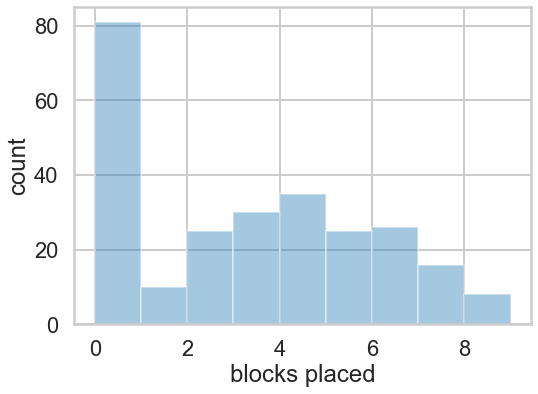

In [69]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(physical_explore['totalExploreBlocks'],
                 bins=9, 
                 kde=False, 
                 #hue='gameID', 
                 #kind='point',
                );
plt.ylabel('count')
plt.xlabel('blocks placed')
plt.title('Physical explore phase, blocks place')
plt.tight_layout()


### Explore vs. exploit question: how many attempts did they make?
Proportion of trials that had 0 attempts (no blocks), 1 attempt, 2+ attempts.

"Attempt" operationalized as explore bout in which >= 1 block placed. 

How many "failures" (tower collapsed/fell over)?

Insofar as num_blocks / attempt is "high," suggestive of instrumental planning as opposed to exploration as such. 

### Within the final prototyping attempt, what did people build?

How similar are the prototypes to the final reconstructions?

- Intersection over Union for every matched time step within-participant, between-phase, within-structure -- compared to IOU for between-participant, btw-phase, within-structure.
- ** block_id "match proportion" metric ... compare observed to null distribution with participants shuffled

If this phase was meant to be practice, for those blocks that they did get to place in the practice phase, did they  place *those* blocks more accurately in the build phase than they did in the practice phase?

- Compute difference in area under the curve ...
- Examine cumulative surface area as function of block placement by phase

How much did the within-trial observed accuracy timecourse deviate from optimal accuracy timecourse?